In [38]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from sklearn.utils import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt

from keras import backend as K
K.set_image_dim_ordering('th')

from keras import callbacks
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam

from sklearn.metrics import classification_report,confusion_matrix
import itertools

TRAIN_DIR = 'C:/Users/PagolPoka/Desktop/Deep_Learning_Project/dataset/training_set'
TEST_DIR = 'C:/Users/PagolPoka/Desktop/Deep_Learning_Project/dataset/test_set'
CLEAN_TEST_DIR = 'C:/Users/PagolPoka/Desktop/test_set/Cleaned_Tanh'
IMG_SIZE = 128
LR = 1e-3
num_channel=1
num_classes = 2
num_epoch=15


MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

In [13]:
def label_img(img):
    
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]    
    if word_label == 'cat': 
        #print("Cat")
        return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': 
        #print("Dog")
        return [0,1]
    
    
##################Fetches all the training pictures from the directory##################
def create_train_data():
    training_data_list = []
    labels_list = []
  
    for folder in tqdm(os.listdir(TRAIN_DIR)):
        if folder != '.DS_Store':
            Train_Path = TRAIN_DIR + '/' + folder
            #print(Train_Path)
            
            for img in tqdm(os.listdir(Train_Path)):
                label = label_img(img)
                path = os.path.join(Train_Path,img)
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                training_data_list.append(img)
                labels_list.append(label)
    
    training_data_raw = training_data_list
    training_data = np.array(training_data_list)    
    training_data = training_data.astype('float32')  
    training_data /= 255
    print ('Shape: ',training_data.shape)
    
    
    labels = np.array(labels_list)
    # print the count of number of samples for different classes
    print(np.unique(labels,return_counts=True))
    
    np.save('train_data.npy', training_data)
    return training_data , labels , training_data_raw




##################Fetches all the noisy test pictures from the directory##################
def create_test_data():
    testing_data_list = []
    test_labels_list = []
  
    for folder in tqdm(os.listdir(TEST_DIR)):
        if folder != '.DS_Store':
            Test_Path = TEST_DIR + '/' + folder
            #print(Test_Path)
            
            for img in tqdm(os.listdir(Test_Path)):
                label = label_img(img)
                path = os.path.join(Test_Path,img)
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                testing_data_list.append(img)
                test_labels_list.append(label)
        
        
    testing_data_raw = testing_data_list
    testing_data = np.array(testing_data_list)    
    testing_data = testing_data.astype('float32')  
    testing_data /= 255
    print ('Shape: ',testing_data.shape)
    
    
    test_labels = np.array(test_labels_list)
    # print the count of number of samples for different classes
    print(np.unique(test_labels,return_counts=True))
    
    np.save('test_data.npy', testing_data)
    return testing_data , test_labels , testing_data_raw




##################Fetches all the training pictures from the directory##################
def create_clean_test_data():
    testing_data_clean_list = []
    test_labels_clean_list = []
  
    for folder in tqdm(os.listdir(CLEAN_TEST_DIR)):
        if folder != '.DS_Store':
            Test_Path = CLEAN_TEST_DIR + '/' + folder
            #print(Test_Path)
            
            for img in tqdm(os.listdir(Test_Path)):
                label = label_img(img)
                path = os.path.join(Test_Path,img)
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                testing_data_clean_list.append(img)
                test_labels_clean_list.append(label)
        
        
    testing_data_raw = testing_data_clean_list
    testing_data_clean = np.array(testing_data_clean_list)    
    testing_data_clean = testing_data_clean.astype('float32')  
    testing_data_clean /= 255
    print ('Shape: ',testing_data_clean.shape)
    
    
    test_labels_clean = np.array(test_labels_clean_list)
    # print the count of number of samples for different classes
    print(np.unique(test_labels_clean_list,return_counts=True))
    
    np.save('test_data.npy', testing_data_clean)
    return testing_data_clean , test_labels_clean , testing_data_raw
            

In [14]:
###############Creating the training data and splitting it into train and test###############
Train_Data, Lables, Train_imgs = create_train_data()
print ("Shape of Train_Data before reshaping: ",Train_Data.shape)

#Reshaping the data to the input format for the CNN model based on the number of channels.
#num_channel==1 [BLACK AND WHITE]
#num_channel==3 [COLOR]
if num_channel==1:
    if K.image_dim_ordering()=='th':
        Train_Data= np.expand_dims(Train_Data, axis=1)
        print (Train_Data.shape)
    else:
        Train_Data= np.expand_dims(Train_Data, axis=4) 
        print (Train_Data.shape)       
else:
    if K.image_dim_ordering()=='th':
        Train_Data=np.rollaxis(Train_Data,3,1)
        print (Train_Data.shape)

        
###############Creating the noisy test data and splitting it into train and test###############        
Test_Data, Test_Lables, Test_imgs = create_test_data()
print (Test_Data.shape)

if num_channel==1:
    if K.image_dim_ordering()=='th':
        Test_Data= np.expand_dims(Test_Data, axis=1)
        print (Test_Data.shape)
    else:
        Test_Data= np.expand_dims(Test_Data, axis=4) 
        print (Test_Data.shape)       
else:
    if K.image_dim_ordering()=='th':
        Test_Data=np.rollaxis(Test_Data,3,1)
        print (Test_Data.shape)

x,y = shuffle(Train_Data,Lables, random_state=2)
test_x, test_y = shuffle(Test_Data,Test_Lables, random_state=2)
#print ("Shape of X_train after reshaping:  ",Train_Data.shape)
#print ("Shape of X_test after reshaping: ",Test_Data.shape)

# Split the dataset
X_train, y_train =(x, y)
print ("Shape of X_train after reshaping:  ",X_train.shape)

# Split the dataset
X_test, y_test = (test_x, test_y)
print ("Shape of X_test after reshaping: ",X_test.shape)



100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.00s/it]


Shape:  (300, 128, 128)
(array([0, 1]), array([300, 300], dtype=int64))
Shape of Train_Data before reshaping:  (300, 128, 128)
(300, 1, 128, 128)


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.32s/it]


Shape:  (150, 128, 128)
(array([0, 1]), array([150, 150], dtype=int64))
(150, 128, 128)
(150, 1, 128, 128)
Shape of X_train after reshaping:   (300, 1, 128, 128)
Shape of X_test after reshaping:  (150, 1, 128, 128)


In [15]:
###############Creating the processed clean test data and splitting it into train and test###############
Test_Data_Clean, Test_Lables_Clean, Test_imgs_Clean = create_clean_test_data()
print (Test_Data_Clean.shape)

if num_channel==1:
    if K.image_dim_ordering()=='th':
        Test_Data_Clean= np.expand_dims(Test_Data_Clean, axis=1)
        print (Test_Data_Clean.shape)
    else:
        Test_Data_Clean= np.expand_dims(Test_Data_Clean, axis=4) 
        print (Test_Data_Clean.shape)       
else:
    if K.image_dim_ordering()=='th':
        Test_Data_Clean=np.rollaxis(Test_Data,3,1)
        print (Test_Data_Clean.shape)

test_clean_x, test_clean_y = shuffle(Test_Data_Clean,Test_Lables_Clean, random_state=2)
print (Test_Data_Clean.shape)

# Split the dataset
X_test_clean, y_test_clean = (test_clean_x, test_clean_y)
print (X_test_clean.shape)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.10it/s]


Shape:  (150, 128, 128)
(array([0, 1]), array([150, 150], dtype=int64))
(150, 128, 128)
(150, 1, 128, 128)
(150, 1, 128, 128)
(150, 1, 128, 128)


150
[[ 97 101 101 ...   5 105 126]
 [112 117 118 ...   2 124 128]
 [120 124 121 ...   0 130 134]
 ...
 [151 150 144 ... 177 169 166]
 [122 127 119 ... 171 169 161]
 [126 130 133 ... 159 160 158]]


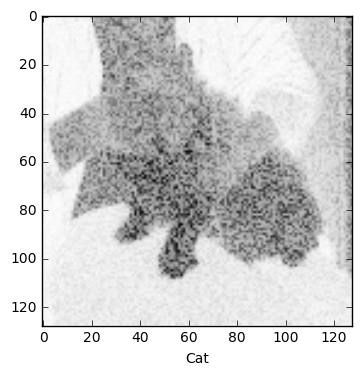

The train label is:  [1 0]


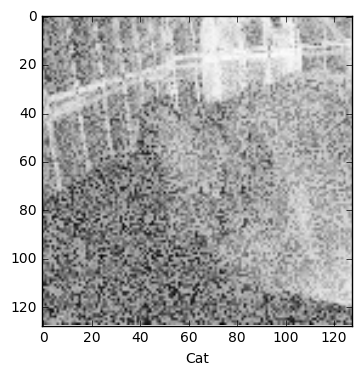

The train label is:  [1 0]


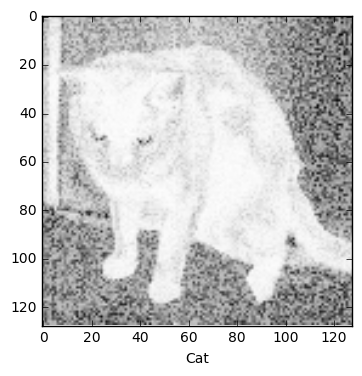

The train label is:  [1 0]


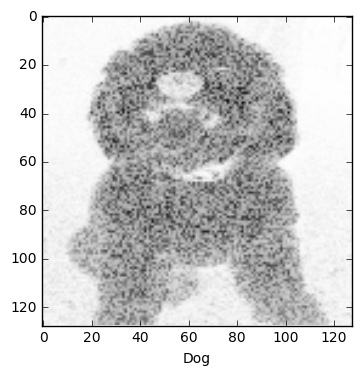

The train label is:  [0 1]


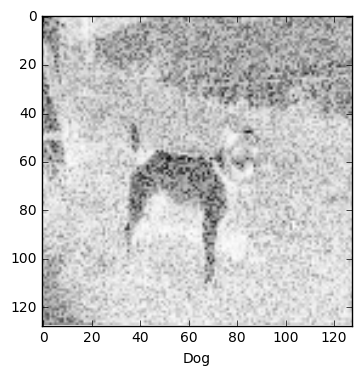

The train label is:  [0 1]


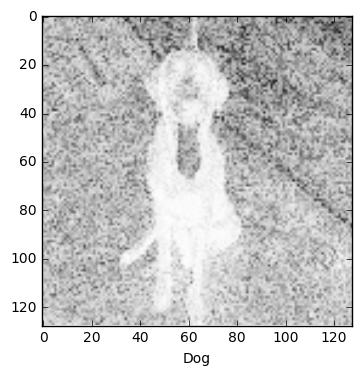

The train label is:  [0 1]


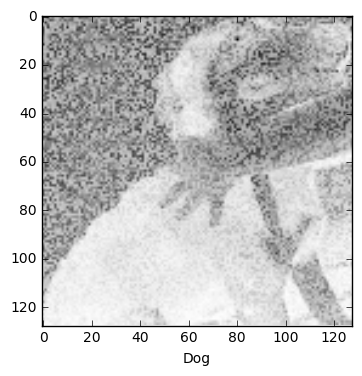

The train label is:  [0 1]


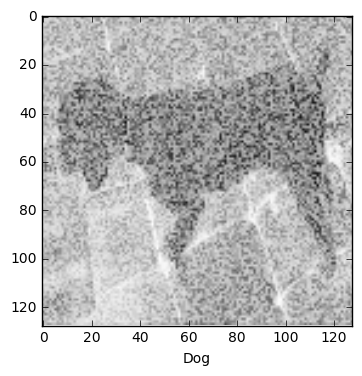

The train label is:  [0 1]


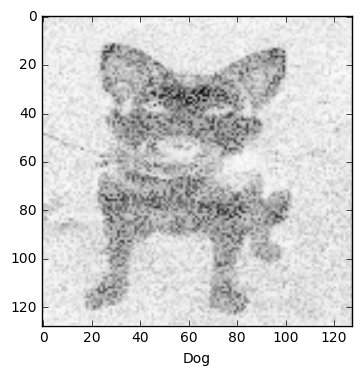

The train label is:  [0 1]


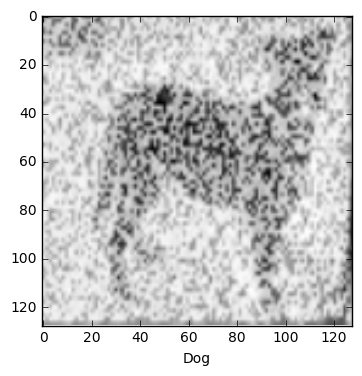

The train label is:  [0 1]


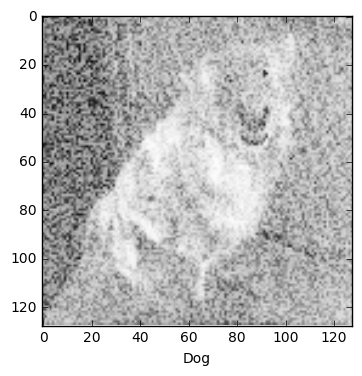

The train label is:  [0 1]


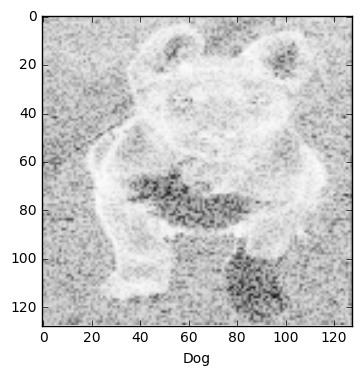

The train label is:  [0 1]


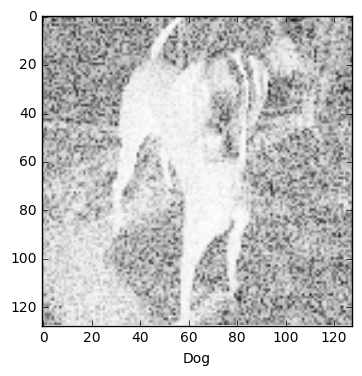

The train label is:  [0 1]
Input Shape:  (1, 128, 128)


In [16]:
#Visualising some of the  noisy test Images
print(len(Test_imgs))
print(Train_imgs[67])

#Displaying 72nd to 85th image from the training clean data
for i in range (72,85):
    plt.figure()
    plt.imshow(Test_imgs[i], cmap=plt.cm.binary)
    lable = Test_Lables[i]
    if lable[0] == 1 :
        plt.xlabel("Cat")
    else:
        plt.xlabel("Dog")
        
    plt.show()    
    print("The train label is: ",Test_Lables[i])


# Defining the model
input_shape=Train_Data[0].shape
print("Input Shape: ", input_shape)


150
[[116 104 103 ...  80  83  89]
 [101  90  90 ...  53  59  70]
 [107  95  94 ...  41  49  63]
 ...
 [ 63  39  32 ...  44  49  71]
 [ 67  44  38 ...  48  55  79]
 [ 70  48  44 ...  56  64  90]]


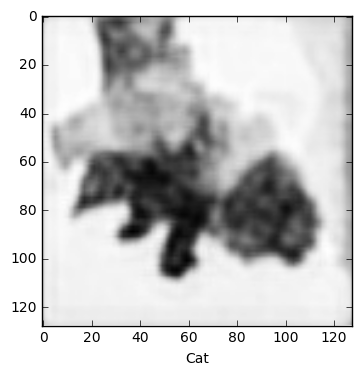

The train label is:  [1 0]


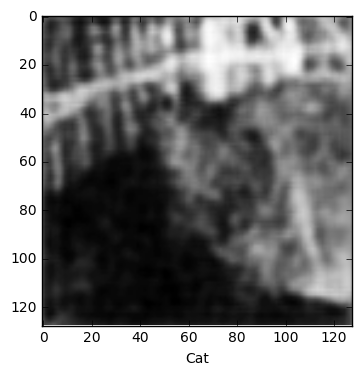

The train label is:  [1 0]


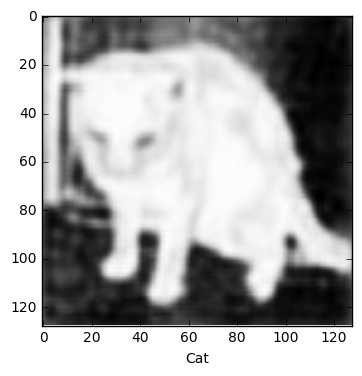

The train label is:  [1 0]


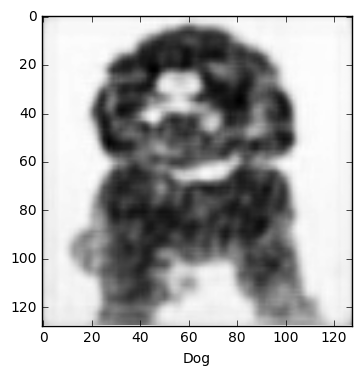

The train label is:  [0 1]


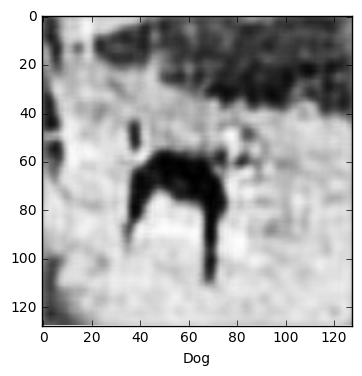

The train label is:  [0 1]


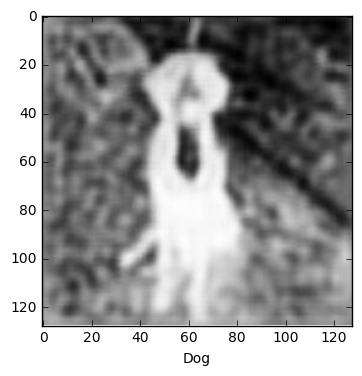

The train label is:  [0 1]


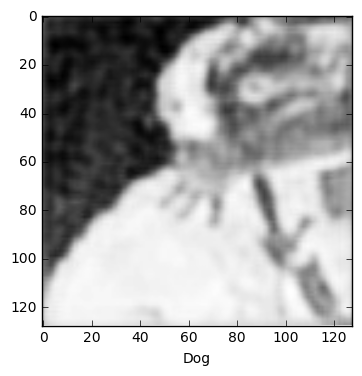

The train label is:  [0 1]


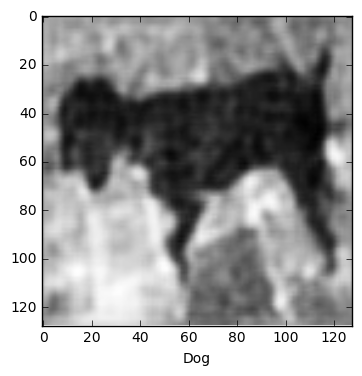

The train label is:  [0 1]


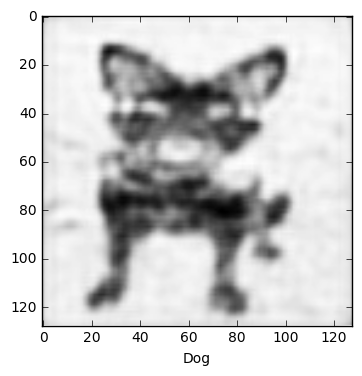

The train label is:  [0 1]


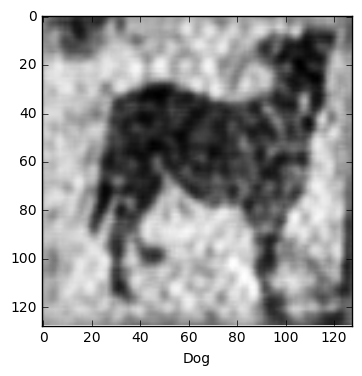

The train label is:  [0 1]


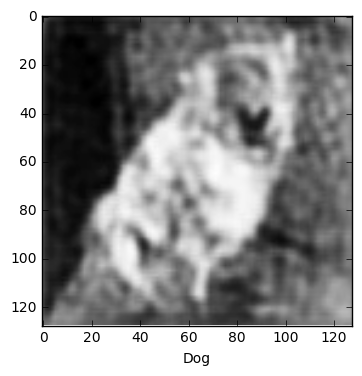

The train label is:  [0 1]


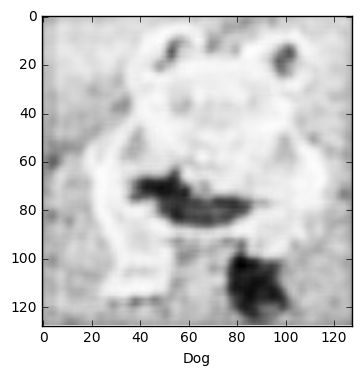

The train label is:  [0 1]


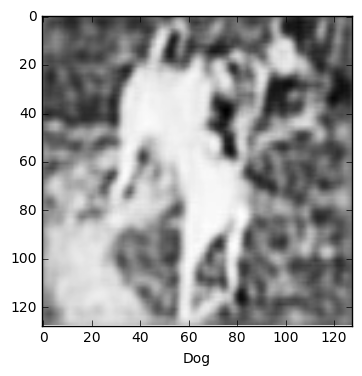

The train label is:  [0 1]


In [18]:
#Visualising some of the  clean processed testing Images
print(len(Test_imgs_Clean))
print(Test_imgs_Clean[67])

#Displaying 72nd to 85th image from the testing clean data
for i in range (72,85):
    plt.figure()
    plt.imshow(Test_imgs_Clean[i], cmap=plt.cm.binary)
    lable = Test_Lables_Clean[i]
    if lable[0] == 1 :
        plt.xlabel("Cat")
    else:
        plt.xlabel("Dog")
        
    plt.show()    
    print("The train label is: ",Test_Lables_Clean[i])




In [19]:
##################Defining the Model################################

model = Sequential()

model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=input_shape, data_format='channels_first'))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
#model.add(Convolution2D(64, 3, 3))
#model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=["accuracy"])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])

# Viewing model_configuration

model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape	
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

C:\Users\PagolPoka\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
C:\Users\PagolPoka\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 126, 126)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 126, 126)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 124, 124)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 124, 124)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 62, 62)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 62, 62)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 60, 60)        18496     
__________

True

In [20]:
print("Shape of the Input Data:"  ,X_train.shape)

Shape of the Input Data: (300, 1, 128, 128)


In [21]:
#####################Training the model with noisy test image###########################
print("Training")
filename='PetClassification_NoisyvalImg_model_train.csv'
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)

early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=num_epoch, verbose=0, mode='min')

filepath="Noisyval_Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [csv_log,early_stopping,checkpoint]

hist = model.fit(X_train, y_train, batch_size=16, nb_epoch=num_epoch, verbose=1, validation_data=(X_test, y_test),callbacks=callbacks_list)

Training


C:\Users\PagolPoka\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 300 samples, validate on 150 samples
Epoch 1/15
300/300 [==============================] - 141s 471ms/step - loss: 6.7620 - acc: 0.5033 - val_loss: 0.6966 - val_acc: 0.4933

Epoch 00001: val_loss improved from inf to 0.69657, saving model to Noisyval_Best-weights-my_model-001-6.7620-0.5033.hdf5
Epoch 2/15
300/300 [==============================] - 68s 228ms/step - loss: 0.8404 - acc: 0.4900 - val_loss: 0.6932 - val_acc: 0.5000

Epoch 00002: val_loss improved from 0.69657 to 0.69318, saving model to Noisyval_Best-weights-my_model-002-0.8404-0.4900.hdf5
Epoch 3/15
300/300 [==============================] - 68s 227ms/step - loss: 0.6910 - acc: 0.5467 - val_loss: 0.6932 - val_acc: 0.5000

Epoch 00003: val_loss did not improve from 0.69318
Epoch 4/15
300/300 [==============================] - 68s 227ms/step - loss: 0.6892 - acc: 0.5333 - val_loss: 0.6931 - val_acc: 0.5000

Epoch 00004: val_loss improved from 0.69318 to 0.69315, saving model to Noisyval_Best-weights-my_model-004-0.6

In [22]:
# Evaluating the model trained with noisy test img
print(len(X_test))
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test noisy accuracy:', test_acc)
print('Test noisy loss:', test_loss)

model.save('CatvsDog_CNN.model')



150
150/150 [==============================] - 22s 147ms/step
Test noisy accuracy: 0.5533333353201548
Test noisy loss: 0.8996289682388305


In [23]:
#####################Training the model with clean test image###########################

print("Training............")
filename='PetClassification_Cleanval_model_clean_train.csv'
csv_log=callbacks.CSVLogger(filename, separator=',', append=False)

early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=num_epoch, verbose=0, mode='min')

filepath="Cleanval_Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [csv_log,early_stopping,checkpoint]

hist_clean = model.fit(X_train, y_train, batch_size=16, nb_epoch=num_epoch, verbose=1, validation_data=(X_test_clean, y_test_clean),callbacks=callbacks_list)

Training............


C:\Users\PagolPoka\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 300 samples, validate on 150 samples
Epoch 1/15
300/300 [==============================] - 71s 237ms/step - loss: 0.3901 - acc: 0.8133 - val_loss: 0.6865 - val_acc: 0.5667

Epoch 00001: val_loss improved from inf to 0.68652, saving model to Cleanval_Best-weights-my_model-001-0.3901-0.8133.hdf5
Epoch 2/15
300/300 [==============================] - 68s 227ms/step - loss: 0.3900 - acc: 0.8133 - val_loss: 0.6790 - val_acc: 0.5667

Epoch 00002: val_loss improved from 0.68652 to 0.67902, saving model to Cleanval_Best-weights-my_model-002-0.3900-0.8133.hdf5
Epoch 3/15
300/300 [==============================] - 69s 229ms/step - loss: 0.3176 - acc: 0.8667 - val_loss: 0.6982 - val_acc: 0.5467

Epoch 00003: val_loss did not improve from 0.67902
Epoch 4/15
300/300 [==============================] - 69s 229ms/step - loss: 0.2345 - acc: 0.9033 - val_loss: 0.8147 - val_acc: 0.5667

Epoch 00004: val_loss did not improve from 0.67902
Epoch 5/15
300/300 [==============================] - 69s 22

In [24]:
# Evaluating the model
print(len(X_test))
test_loss, test_acc = model.evaluate(X_test_clean, y_test_clean)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

model.save('CatvsDog_CNN.model')

150
150/150 [==============================] - 24s 157ms/step
Test accuracy: 0.5733333353201548
Test loss: 1.440830578804016


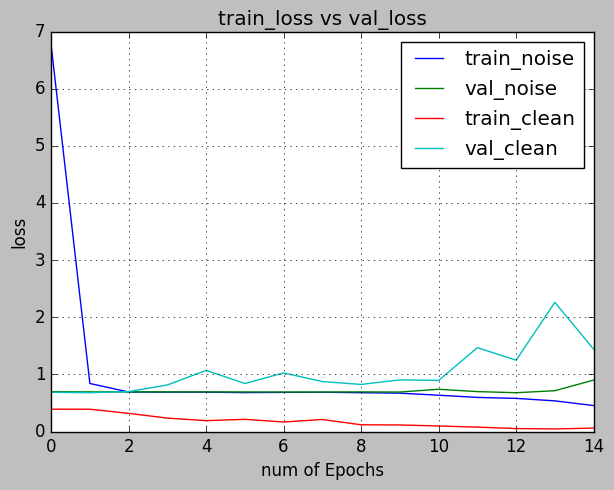

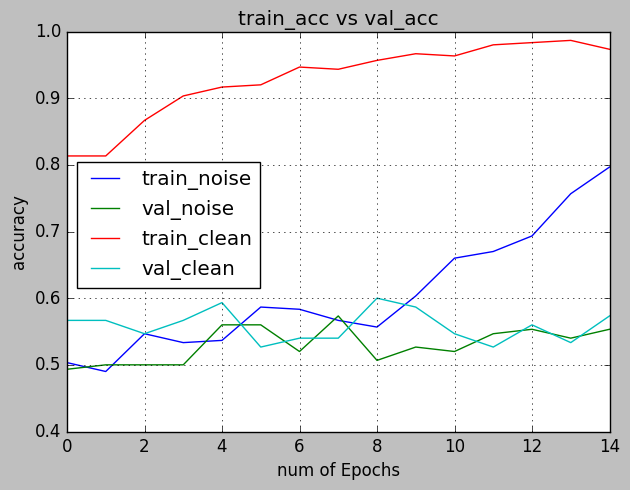

In [49]:
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_loss_clean = hist_clean.history['loss']
val_loss_clean = hist_clean.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
train_acc_clean=hist_clean.history['acc']
val_acc_clean=hist_clean.history['val_acc']
xc=range(num_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.plot(xc,train_loss_clean)
plt.plot(xc,val_loss_clean)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train_noise','val_noise','train_clean', 'val_clean'], loc=0)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])


plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.plot(xc,train_acc_clean)
plt.plot(xc,val_acc_clean)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train_noise','val_noise','train_clean','val_clean'],loc=2, bbox_to_anchor=(0, 0.2, 0.5, 0.5))
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.show()

In [28]:
#Predicting on Noisy Test Data

test_image = X_test[30:40] #Data from index 30 to index 40
lables = y_test[30:40] #Labels from index 30 to index 40
test_image_noise = X_test
print(len(test_image_noise))

True_Lable = []
Predicted_Lable = []
Lable_Compare = [["True"],["Predicted"]]

print("LABLES NAMES OF THE RESPECTIVE IMAGES")
for lable in lables:
    if lable[0] == 1:
        lbl = "Cat"
        print(lable ,"Cat")
    else:
        print(lable, "Dog")
        lbl = "Dog"
    True_Lable.append(lbl)

    


print("")
print("Predicted Probability Value[P(Cat) P(Dog)]: ")
print(model.predict(test_image))

print("")
print("Predicted Results: ")
for i in model.predict_classes(test_image):
    if i == 0:
        print("Cat")
        lbl = "Cat"
    elif i == 1:
        print("Dog")
        lbl = "Dog"
    Predicted_Lable.append(lbl)
    
for i in range(len(Predicted_Lable)):
    Lable_Compare[0].append(True_Lable[i])
    Lable_Compare[1].append(Predicted_Lable[i])
    
print("*************Comparison Between Actual Lable and Predicted Lable****************")
print(Lable_Compare)



150
LABLES NAMES OF THE RESPECTIVE IMAGES
[0 1] Dog
[1 0] Cat
[1 0] Cat
[0 1] Dog
[0 1] Dog
[1 0] Cat
[0 1] Dog
[0 1] Dog
[1 0] Cat
[0 1] Dog

Predicted Probability Value[P(Cat) P(Dog)]: 
[[0.01841524 0.9815848 ]
 [0.06702172 0.9329783 ]
 [0.02322535 0.97677463]
 [0.00478972 0.99521035]
 [0.00125291 0.9987471 ]
 [0.5745395  0.42546052]
 [0.12261752 0.87738246]
 [0.12083917 0.8791608 ]
 [0.94868463 0.05131537]
 [0.3268859  0.6731141 ]]

Predicted Results: 
Dog
Dog
Dog
Dog
Dog
Cat
Dog
Dog
Cat
Dog
*************Comparison Between Actual Lable and Predicted Lable****************
[['True', 'Dog', 'Cat', 'Cat', 'Dog', 'Dog', 'Cat', 'Dog', 'Dog', 'Cat', 'Dog'], ['Predicted', 'Dog', 'Dog', 'Dog', 'Dog', 'Dog', 'Cat', 'Dog', 'Dog', 'Cat', 'Dog']]


In [34]:
#Predicting on Cleaned Test Data
test_image = X_test_clean[30:40] # Data from index 30 to index 40
lables = y_test_clean[30:40] #Labels from index 30 to index 40

test_image_clean = X_test_clean

True_Lable = []
Predicted_Lable = []
Lable_Compare = [["True"],["Predicted"]]

print("LABLES NAMES OF THE RESPECTIVE IMAGES")
for lable in lables:
    if lable[0] == 1:
        lbl = "Cat"
        print(lable ,"Cat")
    else:
        print(lable, "Dog")
        lbl = "Dog"
    True_Lable.append(lbl)

    


print("")
print("Predicted Probability Value[P(Cat) P(Dog)]: ")
print(model.predict(test_image))

print("")
print("Predicted Results: ")
for i in model.predict_classes(test_image):
    if i == 0:
        print("Cat")
        lbl = "Cat"
    elif i == 1:
        print("Dog")
        lbl = "Dog"
    Predicted_Lable.append(lbl)
    
for i in range(len(Predicted_Lable)):
    Lable_Compare[0].append(True_Lable[i])
    Lable_Compare[1].append(Predicted_Lable[i])
    
print("*************Comparison Between Actual Lable and Predicted Lable****************")
print(Lable_Compare)


LABLES NAMES OF THE RESPECTIVE IMAGES
[0 1] Dog
[1 0] Cat
[1 0] Cat
[0 1] Dog
[0 1] Dog
[1 0] Cat
[0 1] Dog
[0 1] Dog
[1 0] Cat
[0 1] Dog

Predicted Probability Value[P(Cat) P(Dog)]: 
[[0.44144064 0.5585593 ]
 [0.9946667  0.00533326]
 [0.05085988 0.9491402 ]
 [0.03801506 0.961985  ]
 [0.00520263 0.99479735]
 [0.6176003  0.38239968]
 [0.09492025 0.9050798 ]
 [0.29880747 0.7011925 ]
 [0.87208134 0.12791868]
 [0.9747491  0.02525093]]

Predicted Results: 
Dog
Cat
Dog
Dog
Dog
Cat
Dog
Dog
Cat
Cat
*************Comparison Between Actual Lable and Predicted Lable****************
[['True', 'Dog', 'Cat', 'Cat', 'Dog', 'Dog', 'Cat', 'Dog', 'Dog', 'Cat', 'Dog'], ['Predicted', 'Dog', 'Cat', 'Dog', 'Dog', 'Dog', 'Cat', 'Dog', 'Dog', 'Cat', 'Cat']]


In [36]:
# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

             precision    recall  f1-score   support

        Cat       0.62      0.45      0.52        75
        Dog       0.57      0.72      0.64        75

avg / total       0.59      0.59      0.58       150

[[34 41]
 [21 54]]

Confusion matrix, without normalization


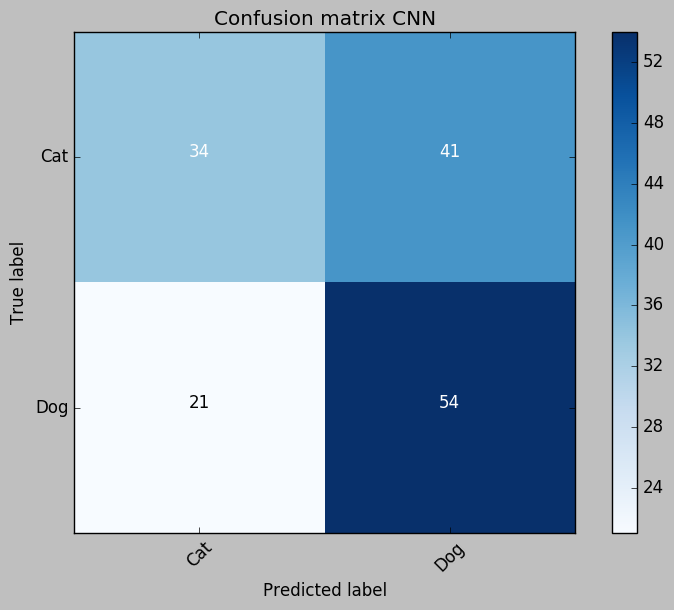

In [44]:
# Printing the confusion matrix for Noisy Test Data

y_pred = model.predict_classes(test_image_noise)
target_names = ['Cat','Dog']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))

cnf_matrix_CNN = confusion_matrix(np.argmax(y_test,axis=1), y_pred)
print(cnf_matrix_CNN)
print("")

np.set_printoptions(precision=2)

plt.figure()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix_CNN, classes=target_names,
                      title='Confusion matrix Noisy Test Data')
plt.show()

             precision    recall  f1-score   support

        Cat       0.58      0.56      0.57        75
        Dog       0.57      0.59      0.58        75

avg / total       0.57      0.57      0.57       150

[[42 33]
 [31 44]]

Confusion matrix, without normalization


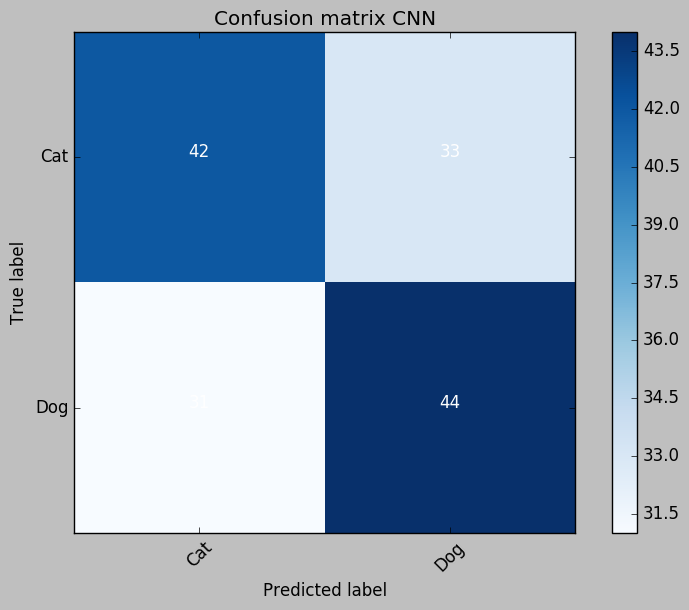

In [43]:
# Printing the confusion matrix for Clean Test Data

y_pred = model.predict_classes(test_image_clean)
target_names = ['Cat','Dog']
print(classification_report(np.argmax(y_test_clean,axis=1), y_pred,target_names=target_names))

cnf_matrix_CNN = confusion_matrix(np.argmax(y_test_clean,axis=1), y_pred)
print(cnf_matrix_CNN)
print("")

np.set_printoptions(precision=2)

plt.figure()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix_CNN, classes=target_names,
                      title='Confusion matrix Clean Test Data')
plt.show()